<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%205/Case_Study_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from numpy import arange
import time

#from example SVM notebook
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import SGDClassifier

Prediction on the Action column, for use with a firewall.

Port is like an address that allows connection like a tv channel.


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%205/log2.csv")
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [5]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


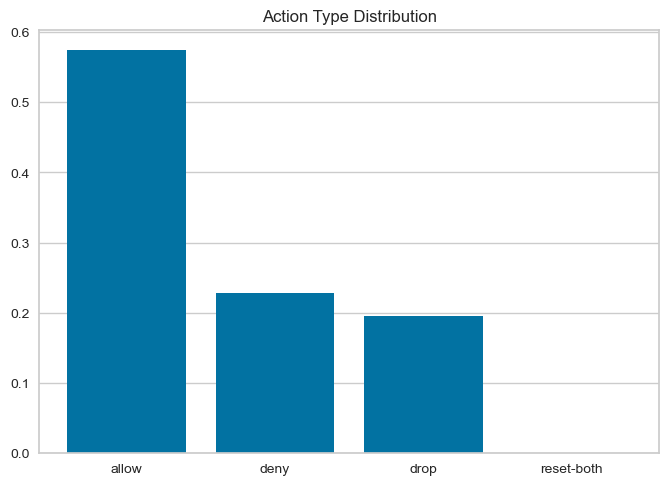

In [6]:
plt.bar(df['Action'].value_counts(normalize=True).index,df['Action'].value_counts(normalize=True))
plt.grid(axis='x')
plt.title('Action Type Distribution')
plt.show()

In [7]:
df['Action'].value_counts(normalize=True)



allow         0.574376
deny          0.228697
drop          0.196103
reset-both    0.000824
Name: Action, dtype: float64

In [8]:
df['Source Port'] = df['Source Port'].astype(str)
df['Destination Port'] = df['Destination Port'].astype(str)
df['NAT Source Port'] = df['NAT Source Port'].astype(str)
df['NAT Destination Port'] = df['NAT Destination Port'].astype(str)

In [9]:
df.describe()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [10]:
value_counts = df['Source Port'].value_counts()
value_counts

58638    840
27005    513
443      273
57470    222
49418    210
        ... 
32996      1
60574      1
60570      1
65368      1
54871      1
Name: Source Port, Length: 22724, dtype: int64

In [11]:
sp_agg = df.groupby(['Source Port']).size().reset_index(name='counts')
sp_agg

,Source Port,counts
0,0,173
1,10000,3
2,10001,2
3,10002,2
4,10003,8
...,...,...
22719,993,19
22720,9957,3
22721,9968,1
22722,9969,1


In [12]:
sp_counts = sp_agg.groupby(['counts']).size().reset_index(name='Number_of_counts')
sp_counts

,counts,Number_of_counts
0,1,9102
1,2,4456
2,3,3481
3,4,1932
4,5,1282
5,6,916
6,7,581
7,8,337
8,9,234
9,10,144


In [13]:
dp_agg = df.groupby(['Destination Port']).size().reset_index(name='counts')
dp_agg

,Destination Port,counts
0,0,173
1,1,85
2,10004,2
3,10010,9
4,10012,2
...,...,...
3268,993,40
3269,995,10
3270,9986,7
3271,9992,1


In [14]:
value_counts = df['Source Port'].value_counts()

#creating list of columns with fewer than 32 values to remove before turning into categorical column (equals .05% of the rows in this dataset)
droplist = pd.DataFrame(value_counts)
droplist = droplist[droplist['Source Port']< 32]
droplist = list(droplist.index.values)

value_counts_DP = df['Destination Port'].value_counts()

#creating list of columns with fewer than 32 values to remove before turning into categorical column (equals .05% of the rows in this dataset)
droplist_DP = pd.DataFrame(value_counts_DP)
droplist_DP = droplist_DP[droplist_DP['Destination Port']< 32]
droplist_DP = list(droplist_DP.index.values)

value_counts_NAT = df['NAT Source Port'].value_counts()
droplist_NAT = pd.DataFrame(value_counts_NAT)
droplist_NAT = droplist_NAT[droplist_NAT['NAT Source Port']< 32]
droplist_NAT = list(droplist_NAT.index.values)

value_counts_NAT_DP = df['NAT Destination Port'].value_counts()
droplist_NAT_DP = pd.DataFrame(value_counts_NAT_DP)
droplist_NAT_DP = droplist_NAT_DP[droplist_NAT_DP['NAT Destination Port']<32]
droplist_NAT_DP = list(droplist_NAT_DP.index.values)

In [15]:
df['Source Port'].value_counts().count()

22724

In [16]:
df['Destination Port'].value_counts().count()

3273

In [17]:
df['NAT Source Port'].value_counts().count()

29152

In [18]:
df['NAT Destination Port'].value_counts().count()

2533

In [19]:
len(droplist)

22691

In [20]:
len(droplist_DP)

3196

In [21]:
len(droplist_NAT)

29149

In [22]:
len(droplist_NAT_DP)

2510

There are 22,724 distinct Source Ports in this dataset.

In [23]:
#i=0

#Replacing low frequency Source Ports (under .05%), with "low-frequency" value, to limit the size of the dataframe

#while i < len(droplist):
#  df['Source Port']=df['Source Port'].replace((droplist[i]),"low-frequency")
#  print(droplist[i])
#  i+=1

# runs a bit faster
sp_list = []
for i in df.index:
    if df['Source Port'][i] in droplist:
        sp_list.append('low-frequency')
    else:
        sp_list.append(df['Source Port'][i])
df['Source Port']=sp_list

In [24]:
#i=0

#Replacing low frequency Source Ports (under .05%), with "Dropped" value, to limit the size of the dataframe

#while i < len(droplist_DP):
#  df['Destination Port']=df['Destination Port'].replace((droplist_DP[i]),"low-frequency")
#  print(droplist_DP[i])
#  i+=1

# runs a bit faster
dp_list = []
for i in df.index:
    if df['Destination Port'][i] in droplist_DP:
        dp_list.append('low-frequency')
    else:
        dp_list.append(df['Destination Port'][i])
df['Destination Port'] = dp_list

In [25]:
nat_list = []
for i in df.index:
    if df['NAT Source Port'][i] in droplist_NAT:
        nat_list.append('low-frequency')
    else:
        nat_list.append(df['NAT Source Port'][i])
df['NAT Source Port'] = nat_list

In [26]:
nat_dp_list = []
for i in df.index:
    if df['NAT Destination Port'][i] in droplist_NAT_DP:
        nat_dp_list.append('low-frequency')
    else:
        nat_dp_list.append(df['NAT Destination Port'][i])
df['NAT Destination Port'] = nat_dp_list

In [27]:
df['Source Port'].value_counts().count()

34

In [28]:
df['Destination Port'].value_counts().count()

78

In [29]:
df['NAT Source Port'].value_counts().count()

4

In [30]:
df['NAT Destination Port'].value_counts().count()

24

In [122]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'Action']

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list((set(cols) - set(num_cols)))

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns,sparse=True)

#creating dataframe of numeric columns
scaler = StandardScaler()
num_df = scaler.fit_transform(X[num_cols])

X=cat_df.join(pd.DataFrame(num_df,columns=X[num_cols].columns, index=X[num_cols].index))

#save column names
col_names = X.columns
X

,Destination Port_0,Destination Port_1,Destination Port_11392,Destination Port_123,Destination Port_1433,Destination Port_15000,Destination Port_15503,Destination Port_161,Destination Port_17372,Destination Port_21247,...,NAT Destination Port_8999,NAT Destination Port_993,NAT Destination Port_low-frequency,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017255,-0.005823,-0.030308,-0.019651,-0.118474,-0.012551,-0.027197
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.016438,-0.005430,-0.029056,-0.016339,-0.161455,-0.009755,-0.023598
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,-0.017244,-0.005817,-0.030293,-0.019651,3.746507,-0.012551,-0.027197
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.016695,-0.005472,-0.029575,-0.017118,-0.161455,-0.010376,-0.024498
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.012773,-0.004077,-0.022799,-0.014001,-0.164761,-0.008823,-0.019550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017231,-0.005798,-0.030293,-0.018871,-0.168067,-0.011619,-0.026747
65528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.815823,0.011736,1.842607,0.890740,0.036919,0.293149,1.632037
65529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646
65530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,-0.017274,-0.005829,-0.030342,-0.019845,-0.217661,-0.012551,-0.027646


Updates for Source & Destination Port, changed column number from 57,689 down to 31,805 by replacing values which represented less than 99.95% of the data overall (to help make the model more efficient, since that is a requirement for this model to be leveraged).

In [123]:
import scipy.sparse

X = scipy.sparse.coo_matrix(X)
X.shape

(65532, 147)

In [33]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['Action']].values.flatten()
#y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

In [34]:
y_alt

array(['allow', 'allow', 'allow', ..., 'drop', 'drop', 'drop'],
      dtype=object)

In [35]:
len(y_alt)

65532

In [36]:
#linear svc
model = LinearSVC(max_iter=100000,tol=0.01,random_state=709,dual=True,class_weight = 'balanced')
X_train,X_test, y_train,y_test = train_test_split(X,y_alt,random_state = 709)
C_list = [.001,.005,.01,.05,.1,.2,.5,.8,1,3,5,10,20,50,100,500,1000,5000,10000,100000]

In [37]:
train_lsvc = pd.DataFrame()
for C in C_list:
    model.C = C
    model.fit(X_train,y_train)
    p=model.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[C])
    train_lsvc = pd.concat([train_lsvc,df_search])
train_lsvc

C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

,accuracy
0.001,0.989013
0.005,0.994018
0.010,0.994018
0.050,0.994873
0.100,0.995361
0.200,0.997131
0.500,0.997436
0.800,0.997436
1.000,0.997742
3.000,0.997742


In [38]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [39]:
# kernel linear
model_svc_l = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='linear')
train_svc_l = pd.DataFrame()
for C in C_list:
    model_svc_l.C = C
    model_svc_l.fit(X_train,y_train)
    p=model_svc_l.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]}, index=[C])
    train_svc_l = pd.concat([train_svc_l,df_search])
train_svc_l

,accuracy
0.001,0.942929
0.005,0.952329
0.010,0.952329
0.050,0.957334
0.100,0.957334
0.200,0.957334
0.500,0.958616
0.800,0.958738
1.000,0.958738
3.000,0.959653


In [40]:
#kernel rbf
model_svc_r = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='rbf')
train_svc_r = pd.DataFrame()
for C in C_list:
    model_svc_r.C = C
    model_svc_r.fit(X_train,y_train)
    p=model_svc_r.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]}, index=[C])
    train_svc_r = pd.concat([train_svc_r,df_search])
train_svc_r

,accuracy
0.001,0.942929
0.005,0.942929
0.010,0.947018
0.050,0.952329
0.100,0.957334
0.200,0.957334
0.500,0.957334
0.800,0.957334
1.000,0.957334
3.000,0.958433


In [41]:
#kernel sigmoid
model_svc_s = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='sigmoid')
train_svc_s = pd.DataFrame()
for C in C_list:
    model_svc_s.C = C
    model_svc_s.fit(X_train,y_train)
    p=model_svc_s.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]}, index=[C])
    train_svc_s = pd.concat([train_svc_s,df_search])
train_svc_s

,accuracy
0.001,0.990722
0.005,0.942929
0.010,0.942929
0.050,0.953244
0.100,0.952329
0.200,0.957334
0.500,0.957334
0.800,0.957334
1.000,0.957334
3.000,0.957334


In [42]:
train_lsvc.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
10000.0,0.998230
100000.0,0.998169
1000.0,0.997986


In [43]:
train_svc_l.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
100000.0,0.961607
10000.0,0.961362
5000.0,0.961240


In [44]:
train_svc_r.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
100000.0,0.961362
10000.0,0.961240
5000.0,0.961179


In [45]:
train_svc_s.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
0.001,0.990722
100000.000,0.961240
10000.000,0.961118


In [73]:
model_lin = LinearSVC(max_iter=100000,tol=0.01,random_state=709,C = 10000,dual=True,class_weight='balanced')
model_lin.fit(X_train,y_train)
start = time.time()
p_linSVC = model_lin.predict(X_test)
stop = time.time()
linsvc_rep = classification_report(y_test,p_linSVC,output_dict=True)
lsvcTime = stop-start

C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [74]:
model_svc_lin = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='linear',C=100000)
model_svc_lin.fit(X_train,y_train)
start = time.time()
p_SVClin = model_svc_lin.predict(X_test)
stop=time.time()
svc_lin_rep = classification_report(y_test,p_SVClin,output_dict=True)
svc_linTime = stop-start

In [75]:
model_svc_rbf = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='rbf',C=100000)
model_svc_rbf.fit(X_train,y_train)
start = time.time()
p_SVCrbf = model_svc_rbf.predict(X_test)
stop=time.time()
svc_rbf_rep = classification_report(y_test,p_SVCrbf,output_dict=True)
svc_rbfTime = stop-start

In [72]:
model_svc_sig = SVC(max_iter=100000,tol=0.01,random_state=709,class_weight='balanced',kernel='sigmoid',C=.001)
model_svc_sig.fit(X_train,y_train)
start = time.time()
p_SVCsig = model_svc_sig.predict(X_test)
stop=time.time()
svc_sig_rep = classification_report(y_test,p_SVCsig,output_dict=True)
svc_sigTime = stop-start

C:\Users\migbo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


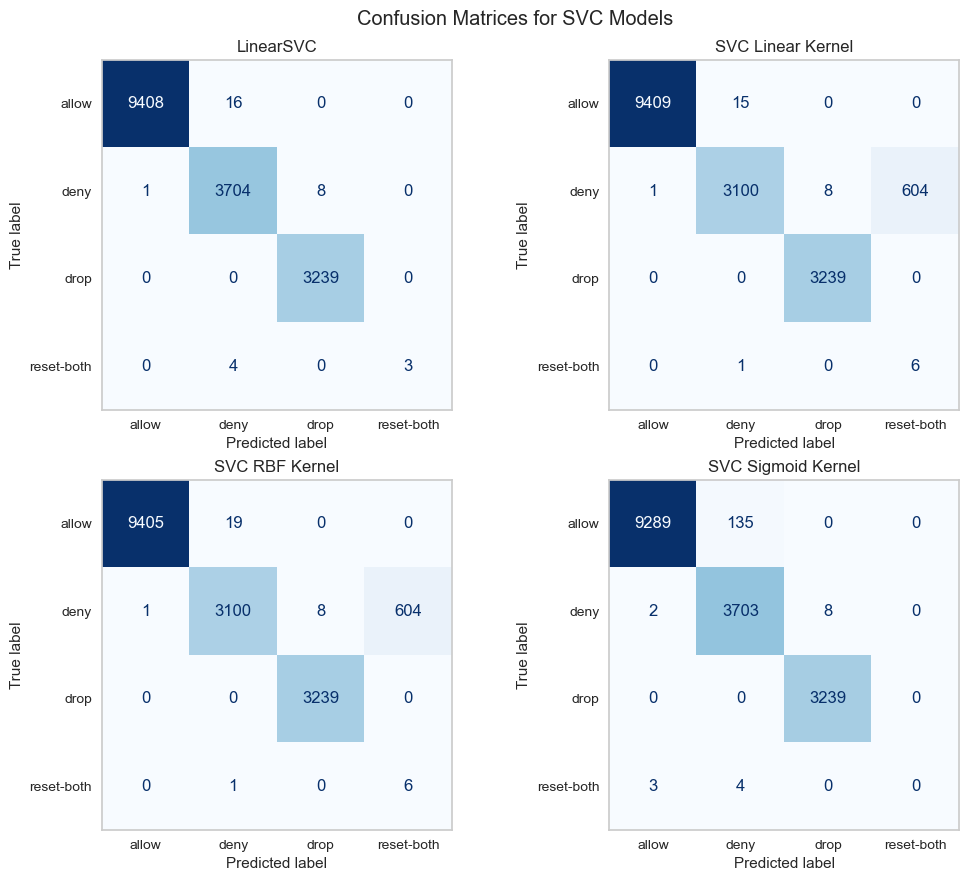

In [76]:
fig, ax = plt.subplots(2,2,figsize = (12,10))
disp_1 = ConfusionMatrixDisplay.from_predictions(y_test,p_linSVC,ax=ax[0][0],colorbar=False,cmap='Blues')
disp_2 = ConfusionMatrixDisplay.from_predictions(y_test,p_SVClin,ax=ax[0][1],colorbar=False,cmap='Blues')
disp_3 = ConfusionMatrixDisplay.from_predictions(y_test,p_SVCrbf,ax=ax[1][0],colorbar=False,cmap = 'Blues')
disp_4 = ConfusionMatrixDisplay.from_predictions(y_test,p_SVCsig,ax=ax[1][1],colorbar=False,cmap = 'Blues')
ax[0][0].grid(False)
ax[0][0].set_title('LinearSVC',fontsize=12)
ax[0][1].grid(False)
ax[0][1].set_title('SVC Linear Kernel',fontsize=12)
ax[1][0].grid(False)
ax[1][0].set_title('SVC RBF Kernel',fontsize=12)
ax[1][1].grid(False)
ax[1][1].set_title('SVC Sigmoid Kernel',fontsize=12)
plt.suptitle('Confusion Matrices for SVC Models',y=.93)
plt.show()

In [51]:
a_list = [0.0001, 0.0005, .001,.005,.01,.05,.1,.2,.5,.8,1,5,10,50,100,500,1000,5000,10000,100000]

In [52]:
#sgd with hinge
from sklearn.linear_model import SGDClassifier
sgd_hin = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='hinge')
train_sgd_hin = pd.DataFrame()
for a in a_list:
    sgd_hin.alpha = a
    sgd_hin.fit(X_train,y_train)
    p = sgd_hin.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[a])
    train_sgd_hin = pd.concat([train_sgd_hin,df_search])
train_sgd_hin

,accuracy
0.0001,0.958249
0.0005,0.958066
0.0010,0.958249
0.0050,0.989013
0.0100,0.989013
0.0500,0.989501
0.1000,0.989868
0.2000,0.989868
0.5000,0.989868
0.8000,0.989868


In [53]:
#sgd with log-loss
from sklearn.linear_model import SGDClassifier
sgd_log = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='log_loss')
train_sgd_log = pd.DataFrame()
for a in a_list:
    sgd_log.alpha = a
    sgd_log.fit(X_train,y_train)
    p = sgd_log.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[a])
    train_sgd_log = pd.concat([train_sgd_log,df_search])
train_sgd_log

,accuracy
0.0001,0.994018
0.0005,0.989013
0.0010,0.989562
0.0050,0.989868
0.0100,0.989868
0.0500,0.989868
0.1000,0.989868
0.2000,0.989868
0.5000,0.989868
0.8000,0.989868


In [54]:
#sgd with modified huber
from sklearn.linear_model import SGDClassifier
sgd_hub = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='modified_huber')
train_sgd_hub = pd.DataFrame()
for a in a_list:
    sgd_hub.alpha = a
    sgd_hub.fit(X_train,y_train)
    p = sgd_hub.predict(X_test)
    df_search = pd.DataFrame({'accuracy':[accuracy_score(y_test,p)]},index=[a])
    train_sgd_hub = pd.concat([train_sgd_hub,df_search])
train_sgd_hub

,accuracy
0.0001,0.958433
0.0005,0.958555
0.0010,0.995727
0.0050,0.993896
0.0100,0.989013
0.0500,0.989868
0.1000,0.989868
0.2000,0.989868
0.5000,0.989868
0.8000,0.989868


In [55]:
train_sgd_hin.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
1.0,0.989868
5.0,0.989868
10.0,0.989868


In [56]:
train_sgd_log.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
0.0001,0.994018
0.2000,0.989868
10.0000,0.989868


In [57]:
train_sgd_hub.sort_values(by='accuracy',ascending=False).head(3)

,accuracy
0.001,0.995727
0.005,0.993896
1.000,0.989868


In [58]:
model_sgdHin = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='hinge',alpha=.05)
model_sgdHin.fit(X_train,y_train)
start=time.time()
p_sgdHin = model_sgdHin.predict(X_test)
stop = time.time()
sgdHin_rep = classification_report(y_test,p_sgdHin,output_dict=True)
sgdHinTime=stop-start

In [59]:
model_sgdLog = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='log_loss',alpha=.001)
model_sgdLog.fit(X_train,y_train)
start=time.time()
p_sgdLog = model_sgdLog.predict(X_test)
stop = time.time()
sgdLog_rep = classification_report(y_test,p_sgdLog,output_dict=True)
sgdLogTime=stop-start

In [60]:
model_sgdHub = SGDClassifier(early_stopping=True,n_iter_no_change=8,class_weight='balanced',max_iter=100000,random_state=709,loss='modified_huber',alpha=.0005)
model_sgdHub.fit(X_train,y_train)
start = time.time()
p_sgdHub = model_sgdHub.predict(X_test)
stop = time.time()
sgdHub_rep = classification_report(y_test,p_sgdHub,output_dict=True)
sgdHubTime = stop-start

In [61]:
model_lin = LinearSVC(max_iter=100000,tol=0.01,random_state=709,C = 20000)
model_lin.fit(X_train,y_train)
start = time.time()
p_linSVC = model_lin.predict(X_test)
stop = time.time()
linsvc_rep = classification_report(y_test,p_linSVC,output_dict=True)
lsvcTime = stop-start

C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\migbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


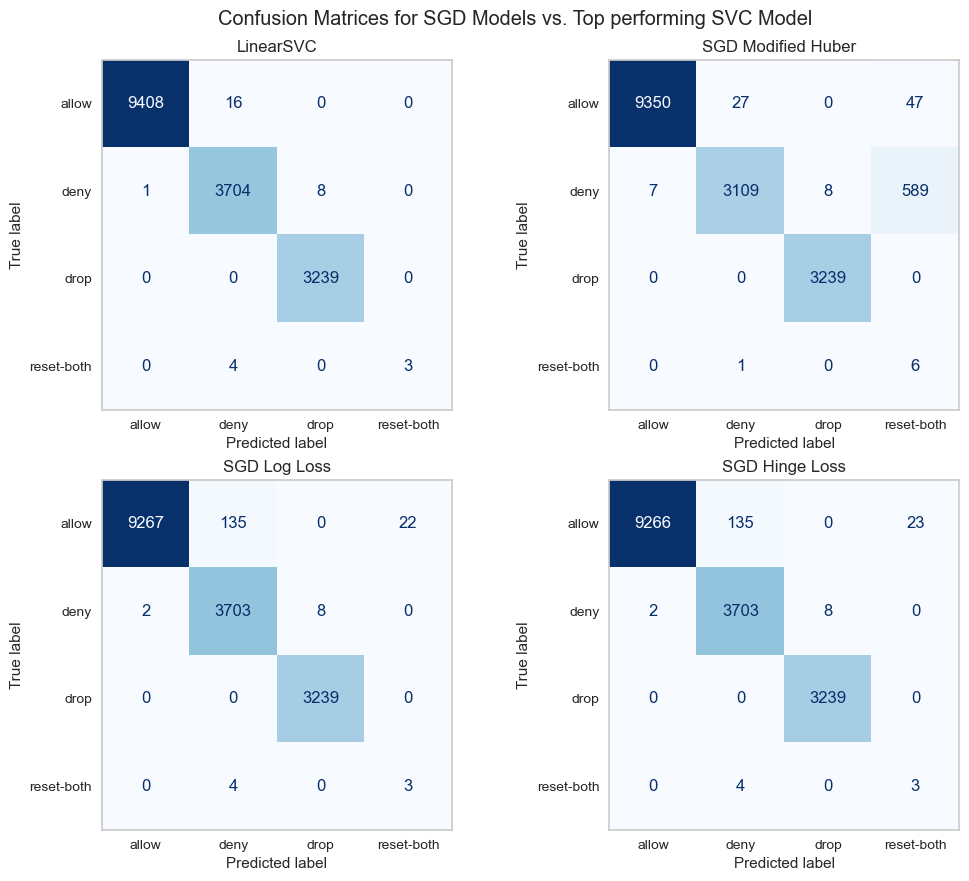

In [77]:

fig, ax = plt.subplots(2,2,figsize = (12,10))
disp_1 = ConfusionMatrixDisplay.from_predictions(y_test,p_linSVC,ax=ax[0][0],colorbar=False,cmap='Blues')
disp_2 = ConfusionMatrixDisplay.from_predictions(y_test,p_sgdHub,ax=ax[0][1],colorbar=False,cmap='Blues')
disp_3 = ConfusionMatrixDisplay.from_predictions(y_test,p_sgdLog,ax=ax[1][0],colorbar=False,cmap='Blues')
disp_4 = ConfusionMatrixDisplay.from_predictions(y_test, p_sgdHin,ax=ax[1][1],colorbar=False,cmap = 'Blues')
ax[0][0].grid(False)
ax[0][0].set_title('LinearSVC',fontsize=12)
ax[0][1].grid(False)
ax[0][1].set_title('SGD Modified Huber  ',fontsize=12)
ax[1][0].grid(False)
ax[1][0].set_title('SGD Log Loss',fontsize=12)
ax[1][1].grid(False)
ax[1][1].set_title('SGD Hinge Loss',fontsize=12)
plt.suptitle('Confusion Matrices for SGD Models vs. Top performing SVC Model',y=.93)
plt.show()

In [105]:
df_results = pd.concat([
    pd.DataFrame({'accuracy':linsvc_rep.get('accuracy'),'weighted avg precision':linsvc_rep.get('weighted avg').get('precision'),'weighted avg recall':linsvc_rep.get('weighted avg').get('recall'),'time':lsvcTime},index=['Linear SVC']),
    pd.DataFrame({'accuracy':svc_lin_rep.get('accuracy'),'weighted avg precision':svc_lin_rep.get('weighted avg').get('precision'),'weighted avg recall':svc_lin_rep.get('weighted avg').get('recall'),'time':svc_linTime},index=['SVC linear kernel']),
    pd.DataFrame({'accuracy':svc_rbf_rep.get('accuracy'),'weighted avg precision':svc_rbf_rep.get('weighted avg').get('precision'),'weighted avg recall':svc_rbf_rep.get('weighted avg').get('recall'),'time':svc_rbfTime},index=['SVC rbf kernel']),
    pd.DataFrame({'accuracy':svc_sig_rep.get('accuracy'),'weighted avg precision':svc_sig_rep.get('weighted avg').get('precision'),'weighted avg recall':svc_sig_rep.get('weighted avg').get('recall'),'time':svc_sigTime},index=['SVC sigmoid kernel']),
    pd.DataFrame({'accuracy':sgdHin_rep.get('accuracy'),'weighted avg precision':sgdHin_rep.get('weighted avg').get('precision'),'weighted avg recall':sgdHin_rep.get('weighted avg').get('recall'),'time':sgdHinTime},index=['SGD hinge loss']),
    pd.DataFrame({'accuracy':sgdLog_rep.get('accuracy'),'weighted avg precision':sgdLog_rep.get('weighted avg').get('precision'),'weighted avg recall':sgdLog_rep.get('weighted avg').get('recall'),'time':sgdLogTime},index=['SGD log loss']),
    pd.DataFrame({'accuracy':sgdHub_rep.get('accuracy'),'weighted avg precision':sgdHub_rep.get('weighted avg').get('precision'),'weighted avg recall':sgdHub_rep.get('weighted avg').get('recall'),'time':sgdHubTime},index=['SGD modified huber loss'])
])

In [106]:
df_results

,accuracy,weighted avg precision,weighted avg recall,time
Linear SVC,0.998230,0.998235,0.998230,0.002992
SVC linear kernel,0.961607,0.997865,0.961607,0.152593
SVC rbf kernel,0.961362,0.997576,0.961362,0.137897
SVC sigmoid kernel,0.990722,0.990577,0.990722,7.591684
SGD hinge loss,0.989501,0.990811,0.989501,0.001994
SGD log loss,0.989562,0.990813,0.989562,0.002003
SGD modified huber loss,0.958555,0.996636,0.958555,0.001987


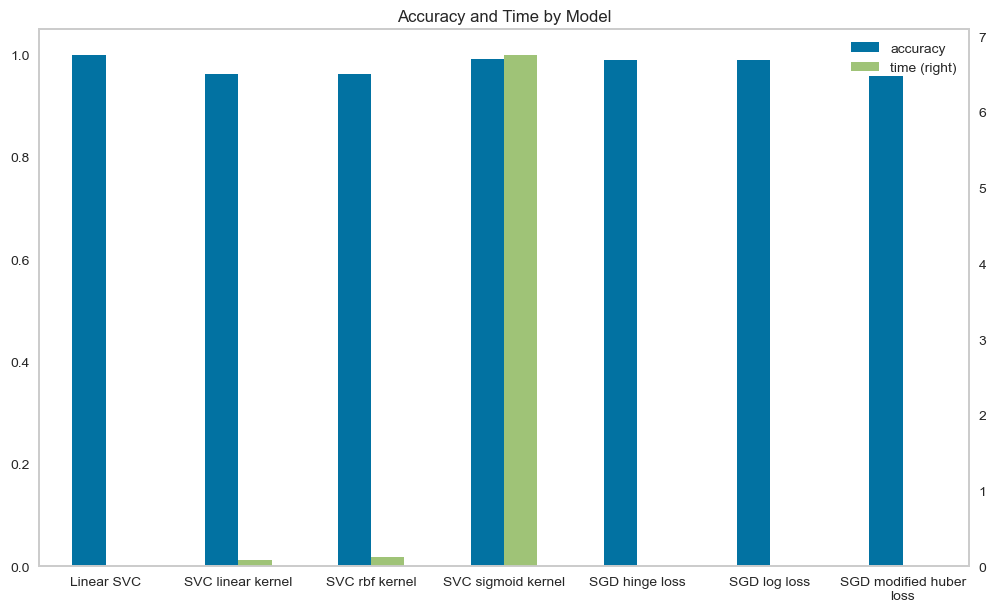

In [98]:

from textwrap import wrap
labels = [ '\n'.join(wrap(l, 20)) for l in df_results.index]

ax = df_results.plot.bar(figsize=(12,3), secondary_y= 'time', rot= 0 )
#df.plot( kind= 'bar' , secondary_y= 'amount' , rot= 0 )
ax.set_xticklabels(labels)
plt.grid(False)
plt.title('Accuracy and Time by Model')
plt.subplots_adjust(top=1.9)

plt.show()

In [127]:
class_labels = model_lin.classes_
df_importances = pd.DataFrame()
for i in range(len(class_labels)):
  importances = model_lin.coef_[i]
  df_temp = pd.DataFrame({'class':class_labels[i],'feature':col_names,'importance':importances})
  df_importances = pd.concat([df_importances,df_temp])


[Text(0.5, 1.0, 'Top Feature Importances for Response (Allow)')]

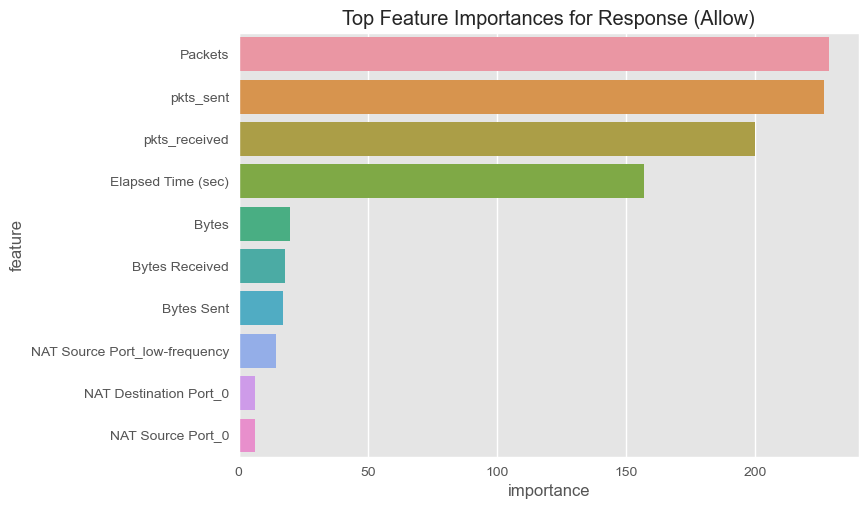

In [164]:
df_allow = df_importances[df_importances['class']=='allow'].sort_values(by='importance',key=abs,ascending=False).head(10)
plt.style.use('ggplot')
sns.barplot(x='importance',y='feature',data= df_allow).set(title = 'Top Feature Importances for Response (Allow)')
#plt.bar(data=df_allow,x='feature',height='importance')

[Text(0.5, 1.0, 'Top Feature Importances for Response (Deny)')]

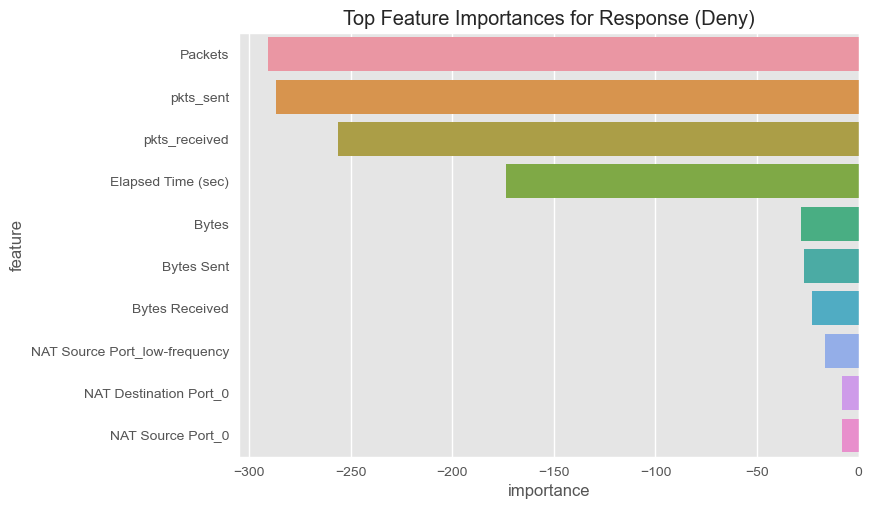

In [165]:
df_deny = df_importances[df_importances['class']=='deny'].sort_values(by='importance',key=abs,ascending=False).head(10)
sns.barplot(x='importance',y='feature',data= df_deny).set(title = 'Top Feature Importances for Response (Deny)')

[Text(0.5, 1.0, 'Top Feature Importances for Response (Drop)')]

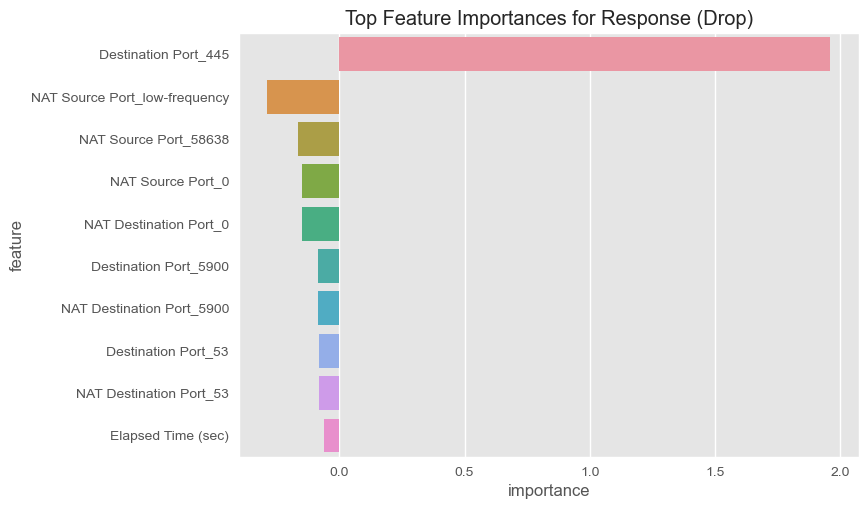

In [166]:
df_drop = df_importances[df_importances['class']=='drop'].sort_values(by='importance',key=abs,ascending=False).head(10)
sns.barplot(x='importance',y='feature',data= df_drop).set(title = 'Top Feature Importances for Response (Drop)')

[Text(0.5, 1.0, 'Top Feature Importances for Response (Reset-Both)')]

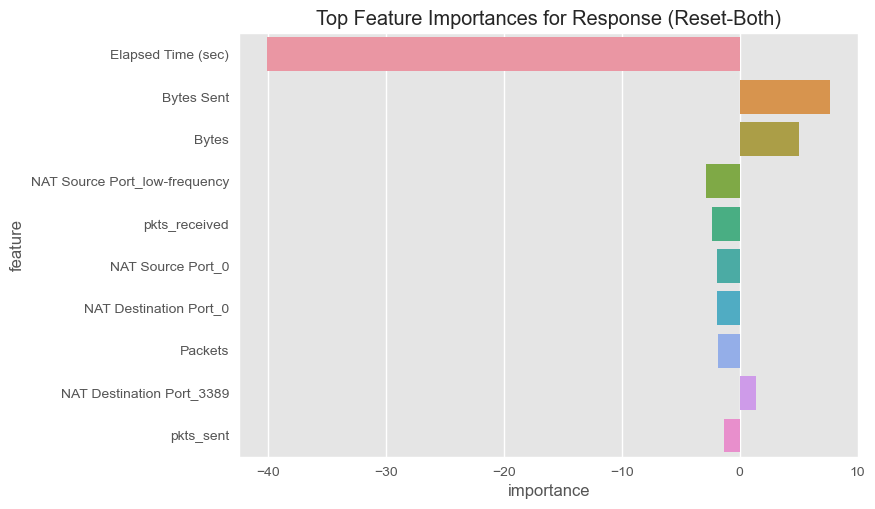

In [167]:
df_reset = df_importances[df_importances['class']=='reset-both'].sort_values(by='importance',key=abs,ascending=False).head(10)
sns.barplot(x='importance',y='feature',data= df_reset).set(title = 'Top Feature Importances for Response (Reset-Both)')